# **Project 2**

## Install Dependencies

In [ ]:
!pip install optuna
!pip install catboost
# !pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00


## Import Library

In [ ]:
# General purpose
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import gaussian_kde

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import HeatMap

# Machine Learning - preprocessing and utilities
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, precision_recall_curve, auc, average_precision_score,
    precision_recall_fscore_support
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
# from imblearn.over_sampling import SMOTE  # optional for handling imbalance
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans

# Machine Learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# from sklearn.neural_network import MLPClassifier  # optional
# from pytorch_tabnet.tab_model import TabNetClassifier  # optional

# Model persistence and deployment
import joblib
import gradio as gr

# Hyperparameter tuning
import optuna

## Load Dataset

In [ ]:
# Baca dua dataset
df1 = pd.read_csv("/content/drive/MyDrive/Proyek/Data/project 2/fraudTrain.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Proyek/Data/project 2/fraudTest.csv")

# Gabungkan dua dataframe
df = pd.concat([df1, df2], ignore_index=True)

# Simpan salinan aslinya
df_temp_ori = df.copy()

# Tampilkan 5 baris pertama
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Initial EDA

In [ ]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [ ]:
len(df)

1852394

In [ ]:
# Ganti label 0/1 jadi lebih jelas
label_map = {0: 'Non-Fraud', 1: 'Fraud'}

# Hitung nilai & persentase
counts = df['is_fraud'].map(label_map).value_counts().reset_index()
counts.columns = ['Status Transaksi', 'Jumlah Transaksi']
counts['Persentase'] = (counts['Jumlah Transaksi'] / counts['Jumlah Transaksi'].sum()) * 100

fig = px.pie(
    counts,
    names='Status Transaksi',
    values='Jumlah Transaksi',
    color='Status Transaksi',
    color_discrete_map={
        'Non-Fraud': '#7BD389',
        'Fraud': '#FF6B6B'
    },
    hole=0.4,
    title='Proporsi Transaksi Fraud vs Non-Fraud'
)

fig.update_traces(
    texttemplate='%{label}<br>%{percent:.1%}',
    textposition='inside',
    hovertemplate='Status: %{label}<br>Jumlah: %{value:,}<br>Persentase: %{percent:.2%}',
    textfont_size=14
)


fig.update_layout(
    title=dict(x=0.5, xanchor='center', font=dict(size=18, color='black')),
    showlegend=True,
    legend_title_text='Status Transaksi',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(t=80, b=60, l=0, r=0)
)

fig.show()

In [ ]:
fraud_count = df['is_fraud'].value_counts()
avg_fraud = df[df['is_fraud'] == 1]['amt'].mean()
avg_nonfraud = df[df['is_fraud'] == 0]['amt'].mean()

print(f"Total transaksi: {len(df):,}")
print(f"Jumlah transaksi fraud: {fraud_count[1]:,}")
print(f"Jumlah transaksi normal: {fraud_count[0]:,}")
print(f"Rata-rata nominal fraud: ${avg_fraud:,.2f}")
print(f"Rata-rata nominal normal: ${avg_nonfraud:,.2f}")

Total transaksi: 1,852,394
Jumlah transaksi fraud: 9,651
Jumlah transaksi normal: 1,842,743
Rata-rata nominal fraud: $530.66
Rata-rata nominal normal: $67.65


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

In [ ]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [ ]:
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [ ]:
df_eda = df[df['is_fraud'] == 1]
df_eda.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,9.651000e+03,9651.000000,9651.000000,9651.000000,9651.000000,9.651000e+03,9.651000e+03,9651.000000,9651.000000,9651.0
mean,3.970393e+17,530.661412,47999.638379,38.742813,-90.033730,8.999842e+04,1.355323e+09,38.734962,-90.037919,1.0
std,1.276696e+18,391.028873,27140.975802,5.153060,14.250246,3.062833e+05,1.793362e+07,5.192904,14.268910,0.0
min,6.041621e+10,1.060000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325466e+09,19.161782,-166.550779,1.0
25%,1.800174e+14,240.075000,24433.000000,35.042850,-96.727000,7.950000e+02,1.339520e+09,35.087441,-96.678370,1.0
50%,3.521261e+15,390.000000,46946.000000,39.537000,-87.043600,2.693000e+03,1.355276e+09,39.516424,-87.167538,1.0
75%,4.603179e+15,902.365000,70447.000000,42.076500,-79.940300,1.905400e+04,1.370567e+09,42.043486,-79.907350,1.0
max,4.992346e+18,1376.040000,99921.000000,66.693300,-67.950300,2.906700e+06,1.387754e+09,67.510267,-66.960745,1.0


In [ ]:
print("Data yg digunakan untuk initial EDA:")
len(df_eda)

Data yg digunakan untuk initial EDA:


9651

In [ ]:
# Pastikan style seaborn rapi
sns.set(style="whitegrid")


In [ ]:
df_eda['fraud_label'] = df_eda['is_fraud'].map({0: 'Non-Fraud', 1: 'Fraud'})

fig = px.box(
    df_eda,
    x='fraud_label',
    y='amt',
    color='fraud_label',
    color_discrete_map={'Non-Fraud': 'skyblue', 'Fraud': 'teal'},
    points='all',
    # range_y=[0, df_eda['amt'].quantile(0.99)],
    title='Distribusi Nilai Transaksi Fraud',
)

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=13),
    xaxis_title='Status Transaksi',
    yaxis_title='Nilai Transaksi Amount',
    legend_title_text='Status Transaksi',
    legend=dict(
        orientation="h",     # horizontal
        yanchor="bottom",
        y=-0.25,             # sedikit turun supaya tdk nempel chart
        xanchor="center",
        x=0.5,
        title_text=None,
        bgcolor='rgba(0,0,0,0)',  # transparan
        bordercolor='rgba(0,0,0,0)'
    ),
    title=dict(x=0.5, font=dict(size=20, family='Arial', color='#333'))  # judul di tengah
)

fig.show()

In [ ]:
# --- Data agregasi ---
df_gender_fraud = (
    df.groupby('gender')['is_fraud']
    .mean()
    .reset_index()
    .sort_values('is_fraud', ascending=False)
)

# --- Mapping label ---
df_gender_fraud['gender_label'] = df_gender_fraud['gender'].map({'M': 'Male', 'F': 'Female'})

# --- Donut chart ---
fig = px.pie(
    df_gender_fraud,
    names='gender_label',  # gunakan label baru
    values='is_fraud',
    hole=0.5,
    color='gender_label',
    color_discrete_map={'Male': '#1f77b4', 'Female': '#e377c2'},
)

# --- Styling dan interaktivitas ---
fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Fraud Rate: %{value:.2%}<extra></extra>',
    pull=[0.01 if v == df_gender_fraud['is_fraud'].max() else 0 for v in df_gender_fraud['is_fraud']]
)

fig.update_layout(
    title='Fraud Rate by Gender',
    title_font=dict(size=20, family='Arial', color='#333'),
    title_x=0.5,  # judul di tengah
    template='plotly_white',
    showlegend=False,
    height=600,
)

fig.show()

In [ ]:
pd.to_datetime(df_eda['trans_date_trans_time']).dt.year.value_counts().sort_index()

,count
trans_date_trans_time,
2019,5220
2020,4431


In [ ]:
df_eda.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'fraud_label'],
      dtype='object')

In [ ]:
m = folium.Map(location=[df['lat'].mean(), df['long'].mean()],
               zoom_start=5, tiles='CartoDB positron')

# Heatmap fraud
HeatMap(
    data=df[df['is_fraud'] == 1][['lat', 'long']].values,
    radius=8, blur=10, gradient={0.4:'blue', 0.65:'lime', 1:'red'}
).add_to(m)

m


In [ ]:
fraud_state = (
    df[df['is_fraud'] == 1]
    .groupby('state')
    .size()
    .reset_index(name='fraud_count')
)

fig = px.choropleth(
    fraud_state,
    locations='state',
    locationmode='USA-states',
    color='fraud_count',
    color_continuous_scale='Tealgrn',
    scope='usa',
    title='Jumlah Transaksi Fraud per State'
)

fig.update_layout(
    title=dict(x=0.5, xanchor='center', font=dict(size=18, color='black')),
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    paper_bgcolor='white',
    margin=dict(t=70, b=20, l=0, r=0)
)

fig.show()

## Feature Engineering + EDA

In [ ]:
df_adv=df_temp_ori.copy()

In [ ]:
df_adv.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
df_adv.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

### Time-based Features

In [ ]:
# ---------------------------------------------------------------
# Mendeteksi fraud di siang/malam hari atau weekday/weekend
# ---------------------------------------------------------------
df_adv['trans_date_trans_time'] = pd.to_datetime(df_adv['trans_date_trans_time'])

df_adv['hour'] = df_adv['trans_date_trans_time'].dt.hour
df_adv['day'] = df_adv['trans_date_trans_time'].dt.day
df_adv['month'] = df_adv['trans_date_trans_time'].dt.month
df_adv['day_of_week'] = df_adv['trans_date_trans_time'].dt.dayofweek
df_adv['is_weekend'] = df_adv['day_of_week'].isin([5, 6]).astype(int)
df_adv['is_night'] = df_adv['hour'].between(0, 6).astype(int)

In [ ]:
# Filter hanya transaksi fraud
hourly_fraud = df_adv[df_adv['is_fraud'] == 1]

# Hitung jumlah transaksi fraud per jam
hourly = hourly_fraud.groupby('hour').size().reset_index(name='count')

# Visualisasi
fig = px.bar(
    hourly,
    x='hour',
    y='count',
    title='Jumlah Transaksi Fraud per Jam',
    labels={'hour': 'Jam', 'count': 'Jumlah Transaksi Fraud'},
    color='count',
    color_continuous_scale='Tealgrn'
)

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=13),
    xaxis=dict(title='Jam Transaksi'),
    yaxis=dict(title='Jumlah Fraud'),
)

fig.show()

In [ ]:
# Data summary
weekend_summary = df_adv.groupby('is_weekend')['is_fraud'].sum().reset_index()
weekend_summary['label'] = weekend_summary['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

fig = px.pie(
    weekend_summary,
    names='label',
    values='is_fraud',
    title='Distribusi Transaksi Fraud: Weekend vs Weekday',
    color='label',
    color_discrete_map={'Weekday': '#008080', 'Weekend': '#20c997'},
    hole=0.45
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    pull=[0.01, 0],  # sedikit efek "tarik keluar" pada satu sisi
    marker=dict(line=dict(color='white', width=2))
)

fig.update_layout(
    showlegend=False,
    title_font=dict(size=20, family='Arial', color='black'),
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(t=80, b=40, l=40, r=40),
    title_x=0.5
)

fig.show()

In [ ]:
# --- Data agregasi ---
night_summary = (
    df_adv.groupby('is_night')['is_fraud']
    .sum()
    .reset_index()
)
night_summary['label'] = night_summary['is_night'].map({0: 'Day', 1: 'Night'})

fig = px.pie(
    night_summary,
    names='label',
    values='is_fraud',
    hole=0.45,
    color='label',
    color_discrete_map={
        'Night': '#008080',
        'Day': '#20c997'
    },
    title='Distribusi Transaksi Fraud: Night vs Day'
)


fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Jumlah Fraud: %{value:,}<extra></extra>',
    pull=[0.01 if v == night_summary['is_fraud'].max() else 0 for v in night_summary['is_fraud']],
    marker=dict(line=dict(color='white', width=2))
)

fig.update_layout(
    title=dict(x=0.5, font=dict(size=20, family='Arial', color='#333')),
    template='plotly_white',
    showlegend=False,
    height=600,
    margin=dict(t=80, b=40, l=40, r=40)
)

fig.show()

In [ ]:
# --- Data agregasi (heatmap source) ---
heatmap = df_adv.pivot_table(
    index='hour',
    columns='is_weekend',
    values='is_fraud',
    aggfunc='sum'
)

# --- Label kolom weekend ---
heatmap.columns = ['Weekday', 'Weekend']

# --- Heatmap modern & readable ---
fig = px.imshow(
    heatmap,
    labels=dict(x="", y="Hour of Transaction", color="Fraud Count"),
    x=heatmap.columns,
    y=heatmap.index,
    color_continuous_scale='Tealgrn',
    text_auto=True,
    aspect="auto"
)

# --- Styling agar mudah dibaca ---
fig.update_traces(
    texttemplate="%{text:.0f}",       # angka bulat
    textfont=dict(size=12, color="black"),  # teks hitam biar kontras
    hovertemplate="Hour %{y}: %{x}<br>Fraud Count: %{z:,}<extra></extra>"
)

fig.update_layout(
    title=dict(
        text="Distribusi Jumlah Fraud per Jam: Weekday vs Weekend",
        x=0.5,
        y=0.97,
        font=dict(size=20, family="Arial", color="#333")
    ),
    xaxis=dict(
        title="Day Type",
        side="top",
        tickfont=dict(size=13),
        showgrid=False
    ),
    yaxis=dict(
        title="Hour (0–23)",
        tickfont=dict(size=13),
        autorange="reversed"  # biar jam 0 di atas (opsional)
    ),
    coloraxis_colorbar=dict(
        title="Fraud Count",
        tickfont=dict(size=12)
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(t=100, b=40, l=60, r=40)
)

fig.show()

### Location-based Features

In [ ]:
# ---------------------------------------------------------------
# Semakin jauh jarak antara lokasi merchant dan user -> indikasi fraud
# ---------------------------------------------------------------

# Menghitung jarak antara dua titik di permukaan bumi berdasarkan koordinat latitude dan longitude-nya,
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius bumi dalam km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df_adv['distance_km'] = haversine(df_adv['lat'], df_adv['long'], df_adv['merch_lat'], df_adv['merch_long'])


In [ ]:
# Filter hanya transaksi fraud
df_fraud = df_adv[df_adv['is_fraud'] == 1]

# Tentukan persentil untuk high-risk (top 1%)
percentile = 99
threshold = np.percentile(df_fraud['distance_km'], percentile)
print(f"Threshold high-risk (top 1% fraud): {threshold:.2f} km")

# Hitung histogram jarak fraud
hist_counts, bin_edges = np.histogram(df_fraud['distance_km'], bins=100)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Pisahkan data untuk Normal dan High-Risk
hist_normal = [c if c <= threshold else 0 for c in bin_centers]
hist_highrisk = [c if c > threshold else 0 for c in bin_centers]

# Atau lebih aman: buat mask untuk y
y_normal = [hist_counts[i] if bin_centers[i] <= threshold else 0 for i in range(len(bin_centers))]
y_highrisk = [hist_counts[i] if bin_centers[i] > threshold else 0 for i in range(len(bin_centers))]

# Buat figure
fig = go.Figure()

# Trace Normal
fig.add_trace(go.Bar(
    x=bin_centers,
    y=y_normal,
    marker_color='#7fcdbb',
    name='Normal',
))

# Trace High-Risk
fig.add_trace(go.Bar(
    x=bin_centers,
    y=y_highrisk,
    marker_color='#e31a1c',
    name='High-Risk',
))

# Layout
fig.update_layout(
    title=dict(text='Distribusi Jarak User–Merchant (Fraud Transactions – Top 1%)', x=0.5),
    xaxis_title='Distance (km)',
    yaxis=dict(
        title='Jumlah Transaksi Fraud',
        type='log',
        tickformat=',',
        tickvals=[1, 10, 100, 1000, 10000, 100000],
        ticktext=['1', '10', '100', '1K', '10K', '100K']
    ),
    legend=dict(x=0.9, y=0.95),
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=13)
)

fig.show()

Threshold high-risk (top 1% fraud): 132.30 km


### User Demographics

In [ ]:
# ---------------------------------------------------------------
# Fraud bisa lebih sering pada usia tertentu
# ---------------------------------------------------------------
df_adv['dob'] = pd.to_datetime(df_adv['dob'], errors='coerce')
df_adv['trans_date_trans_time'] = pd.to_datetime(df_adv['trans_date_trans_time'], errors='coerce')

# Hitung umur dalam tahun (dibulatkan ke bawah)
df_adv['age'] = (df_adv['trans_date_trans_time'] - df_adv['dob']).dt.days // 365


In [ ]:
# --- Buat age bins ---
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18-24','25-34','35-44','45-54','55-64','65-74','75+']
df_adv['age_group'] = pd.cut(df_adv['age'], bins=bins, labels=labels, right=False)

# --- Filter hanya transaksi fraud ---
fraud_only = df_adv[df_adv['is_fraud'] == 1]

# --- Hitung jumlah fraud per age group ---
fraud_count_by_age = (
    fraud_only.groupby('age_group')['is_fraud']
    .count()
    .reset_index()
    .rename(columns={'is_fraud': 'fraud_count'})
    .sort_values('fraud_count', ascending=False)
)

# --- Donut chart ---
fig = px.pie(
    fraud_count_by_age,
    names='age_group',
    values='fraud_count',
    color='age_group',
    color_discrete_sequence=px.colors.sequential.RdBu_r,
    hole=0.45,
    title='Distribusi Jumlah Fraud per Age Group'
)

# --- Atur teks & highlight tertinggi ---
fig.update_traces(
    texttemplate='%{label}<br>%{value:,}',  # tampilkan label + jumlah fraud
    textposition='inside',
    hovertemplate='<b>%{label}</b><br>Jumlah Fraud: %{value:,}<extra></extra>',
    pull=[0.05 if v == fraud_count_by_age['fraud_count'].max() else 0 for v in fraud_count_by_age['fraud_count']]
)

# --- Layout ---
fig.update_layout(
    title_font=dict(size=20, family='Arial', color='#333'),
    showlegend=False,
    template='plotly_white',
    height=600,
    title_x=0.5
)

fig.show()

### User Behavior / Frequency

In [ ]:
# ---------------------------------------------------------------
# Lonjakan transaksi dalam waktu singkat -> indikasi fraud
# ---------------------------------------------------------------
df_adv = df_adv.sort_values(['cc_num', 'trans_date_trans_time'])

# Hitung jumlah transaksi dalam 1 hari terakhir per kartu
df_adv['trans_count_1d'] = (
    df_adv.groupby('cc_num', group_keys=False)
    .apply(lambda x: (
        x.set_index('trans_date_trans_time')
         .rolling('1D')['cc_num']
         .count()
    ))
    .reset_index(level=0, drop=True)
)

# Hitung jumlah transaksi dalam 7 hari terakhir per kartu
df_adv['trans_count_7d'] = (
    df_adv.groupby('cc_num', group_keys=False)
    .apply(lambda x: (
        x.set_index('trans_date_trans_time')
         .rolling('7D')['cc_num']
         .count()
    ))
    .reset_index(level=0, drop=True)
)

In [ ]:
# Filter hanya transaksi fraud
fraud_only = df_adv[df_adv['is_fraud'] == 1]

# Hitung threshold top 1% berdasarkan data fraud saja
threshold_1d = np.percentile(fraud_only['trans_count_1d'], 99)
print(f"Threshold high-risk (top 1% fraud): {threshold_1d:.2f}")

# Histogram distribusi
fig_1d = px.histogram(
    fraud_only,
    x='trans_count_1d',
    nbins=50,
    color=np.where(fraud_only['trans_count_1d'] > threshold_1d, 'High Risk', 'Normal'),
    color_discrete_map={'Normal': '#7fcdbb', 'High Risk': '#e31a1c'},
    title='Distribusi Jumlah Transaksi 1 Hari per Kartu',
    labels={'trans_count_1d': 'Jumlah Transaksi (1 Hari)', 'count': 'Jumlah Kartu'}
)

# Layout dan tampilan
fig_1d.update_traces(opacity=0.85)
fig_1d.update_layout(
    title_font=dict(size=20, family='Arial', color='#333'),
    xaxis_title='Jumlah Transaksi (1 Hari)',
    yaxis_title='Jumlah Kartu (Fraud)',
    template='plotly_white',
    showlegend=True,
    legend_title_text='Kategori Risiko',
    margin=dict(t=80, b=40, l=40, r=40),
    legend=dict(
        x=0.9,      # geser legend ke kanan
        y=0.95,      # tetap atas
        xanchor='left',  # anchor kiri legend ke x
        yanchor='top',   # anchor atas legend ke y
        bgcolor='rgba(0,0,0,0)',  # transparan
    ),
)

fig_1d.show()

Threshold high-risk (top 1% fraud): 16.00


In [ ]:
# Filter hanya transaksi fraud
fraud_only = df_adv[df_adv['is_fraud'] == 1]

# Hitung threshold top 1% (berdasarkan data fraud saja)
threshold_7d = np.percentile(fraud_only['trans_count_7d'], 99)
print(f"Threshold high-risk (top 1% fraud): {threshold_7d:.2f}")

# Histogram distribusi transaksi 7 hari (fraud only)
fig_7d = px.histogram(
    fraud_only,
    x='trans_count_7d',
    nbins=50,
    color=np.where(fraud_only['trans_count_7d'] > threshold_7d, 'High Risk', 'Normal'),
    color_discrete_map={'Normal': '#7fcdbb', 'High Risk': '#e31a1c'},
    title='Distribusi Jumlah Transaksi 7 Hari per Kartu',
    labels={'trans_count_7d': 'Jumlah Transaksi (7 Hari)', 'count': 'Jumlah Kartu'}
)

# Layout & style
fig_7d.update_traces(opacity=0.85)
fig_7d.update_layout(
    title_font=dict(size=20, family='Arial', color='#333'),
    xaxis_title='Jumlah Transaksi (7 Hari)',
    yaxis_title='Jumlah Kartu (Fraud)',
    template='plotly_white',
    showlegend=True,
    legend_title_text='Kategori Risiko',
    margin=dict(t=80, b=40, l=40, r=40),
    legend=dict(
        x=0.9,      # geser legend ke kanan
        y=0.95,      # tetap atas
        xanchor='left',  # anchor kiri legend ke x
        yanchor='top',   # anchor atas legend ke y
        bgcolor='rgba(0,0,0,0)',  # transparan
    ),
)


fig_7d.show()

Threshold high-risk (top 1% fraud): 76.00


threshold nya top 1% (nilai > 30 transaksi dalam 7 hari).
Artinya, bin ke-3 (20–30) bisa berisi campuran data:

Sebagian besar transaksi “Normal” (misal 21, 25)

Sebagian kecil transaksi “High Risk” (misal 31, 32, 33)

Jadi histogram akan menampilkan dua warna dalam satu bar (misalnya hijau muda dan merah)

### Amount Anomalies

In [ ]:
# ---------------------------------------------------------------
# Transaksi jauh lebih besar dari rata-rata user bisa jadi fraud
# ---------------------------------------------------------------
df_adv['avg_amt_per_user'] = df_adv.groupby('cc_num')['amt'].transform('mean')
df_adv['amt_ratio_to_avg'] = df_adv['amt'] / (df_adv['avg_amt_per_user'] + 1e-5) #1e-5 mencegah ZeroDivisionError


In [ ]:
fraud_only = df_adv[df_adv['is_fraud'] == 1]

# Hitung threshold top 1% untuk rasio transaksi
threshold_ratio = np.percentile(fraud_only['amt_ratio_to_avg'], 99)

print(f"Threshold High-Risk (Top 1%) untuk Fraud: {threshold_ratio:.2f}")

# Histogram fraud-only dengan kategori risiko
fig_ratio = px.histogram(
    fraud_only,
    x='amt_ratio_to_avg',
    color=np.where(fraud_only['amt_ratio_to_avg'] > threshold_ratio, 'High Risk', 'Normal'),
    nbins=50,
    color_discrete_map={'Normal': '#7fcdbb', 'High Risk': '#e31a1c'},
    title='Distribusi Rasio Transaksi terhadap Rata-rata User',
    labels={'amt_ratio_to_avg': 'Rasio Transaksi / Rata-rata User', 'count': 'Jumlah Transaksi'},
    barmode='stack'
)

# Styling layout
fig_ratio.update_yaxes(type='log')  # log scale agar perbedaan terlihat jelas
fig_ratio.update_layout(
    template='plotly_white',
    title_font=dict(size=20, family='Arial', color='#333'),
    legend=dict(title='Kategori Risiko', x=0.8, y=0.95),
    xaxis_title='Rasio Transaksi terhadap Rata-rata User',
    yaxis_title='Jumlah Transaksi Fraud'
)

fig_ratio.show()

Threshold High-Risk (Top 1%) untuk Fraud: 19.52


### Merchant and Category Risk

In [ ]:
# ---------------------------------------------------------------
# Merchant atau kategori tertentu lebih rawan fraud
# ---------------------------------------------------------------
merchant_fraud_rate = df_adv.groupby('merchant')['is_fraud'].mean()
df_adv['merchant_fraud_rate'] = df_adv['merchant'].map(merchant_fraud_rate)

category_fraud_rate = df_adv.groupby('category')['is_fraud'].mean()
df_adv['category_fraud_rate'] = df_adv['category'].map(category_fraud_rate)

In [ ]:
# Filter hanya transaksi fraud
df_fraud = df_adv[df_adv['is_fraud'] == 1]

# Ambil merchant dengan fraud rate tertinggi berdasarkan kolom yang sudah ada
top_merchants = (
    df_fraud[['merchant', 'merchant_fraud_rate']]
    .drop_duplicates(subset=['merchant'])
    .sort_values(by='merchant_fraud_rate', ascending=False)
    .head(20)
)

# Visualisasi
fig_merchant = px.bar(
    top_merchants,
    x='merchant_fraud_rate',
    y='merchant',
    orientation='h',
    color='merchant_fraud_rate',
    color_continuous_scale='Tealgrn',
    title='Merchant Paling Rawan Fraud',
    labels={'merchant_fraud_rate': 'Fraud Rate', 'merchant': 'Merchant'}
)

fig_merchant.update_layout(
    yaxis=dict(autorange='reversed'),
    template='plotly_white',
    height=600
)

fig_merchant.show()

In [ ]:
# Ambil top 20 kategori dengan fraud rate tertinggi
top_categories = (
    df_fraud[['category', 'category_fraud_rate']]
    .drop_duplicates(subset=['category'])
    .sort_values(by='category_fraud_rate', ascending=False)
    # .head(20)
)

fig_category = px.bar(
    top_categories,
    x='category_fraud_rate',
    y='category',
    orientation='h',
    color='category_fraud_rate',
    color_continuous_scale='Tealgrn',
    title='Kategori Paling Rawan Fraud',
    labels={'category_fraud_rate': 'Fraud Rate', 'category': 'Kategori'}
)

fig_category.update_layout(
    yaxis=dict(autorange='reversed'),
    template='plotly_white',
    height=600
)

fig_category.show()

### Rolling Statistics & Transaction Amount Anomalies

In [ ]:
# ---------------------------------------------------------------
# Lonjakan mendadak dari transaksi sebelumnya -> indikasi anomali
# ---------------------------------------------------------------
df_adv['amt_rolling_mean_3'] = (
    df_adv.groupby('cc_num')['amt']
    .transform(lambda x: x.rolling(3, min_periods=1).mean())
)
df_adv['amt_diff'] = df_adv.groupby('cc_num')['amt'].diff().fillna(0)


In [ ]:
# amt_diff bukan transaksi antar kartu atau antar orang, tapi perbandingan transaksi berurutan dari kartu yang sama.
df_fraud = df_adv[df_adv['is_fraud'] == 1]

# Threshold top 1% selisih transaksi sebagai high-risk (berdasarkan data fraud)
threshold_diff = np.percentile(df_fraud['amt_diff'], 99)

# Histogram stacked high-risk vs normal (fraud only)
fig_diff = px.histogram(
    df_fraud,
    x='amt_diff',
    color=np.where(df_fraud['amt_diff'] > threshold_diff, 'High Risk', 'Normal'),
    nbins=50,
    color_discrete_map={'Normal': '#7fcdbb', 'High Risk': '#e31a1c'},
    title='Distribusi Lonjakan Transaksi Antar-Transaksi per Kartu',
    labels={'amt_diff': 'Selisih Transaksi', 'count': 'Jumlah Transaksi'},
    barmode='stack'
)

# log scale supaya outlier kelihatan
fig_diff.update_yaxes(type='log')

fig_diff.update_layout(
    template='plotly_white',
    title_font=dict(size=20, family='Arial', color='#333'),
    legend=dict(title='Kategori Risiko', x=0.9, y=0.95)
)

fig_diff.show()

### Merchant Location & Customer Behavior (Clustering)

In [ ]:
# ---------------------------------------------------------------
# Clustering untuk mendeteksi lokasi tidak biasa bagi user
# ---------------------------------------------------------------

coords = df_adv[['merch_lat', 'merch_long']]
kmeans = KMeans(n_clusters=10, random_state=42) # ideal cluster=10, assumption
df_adv['merchant_cluster'] = kmeans.fit_predict(coords)

user_common_cluster = df_adv.groupby('cc_num')['merchant_cluster'].agg(lambda x: x.value_counts().idxmax())
df_adv['user_main_cluster'] = df_adv['cc_num'].map(user_common_cluster)
df_adv['is_outlier_location'] = (df_adv['merchant_cluster'] != df_adv['user_main_cluster']).astype(int)
# Jika user tiba-tiba belanja di lokasi yang tidak biasa -> indikasi fraud.

In [ ]:
# Filter hanya transaksi fraud
df_fraud = df_adv[df_adv['is_fraud'] == 1]

# Hitung jumlah outlier lokasi per merchant_cluster
outlier_count = (
    df_fraud.groupby('merchant_cluster')['is_outlier_location']
    .sum()
    .reset_index()
)

# Bar chart
fig_outlier = px.bar(
    outlier_count,
    x='merchant_cluster',
    y='is_outlier_location',
    color='is_outlier_location',
    color_continuous_scale='Tealgrn',
    title='Jumlah Transaksi Fraud di Lokasi Tidak Biasa per Cluster',
    labels={'merchant_cluster': 'Cluster', 'is_outlier_location': 'Jumlah Outlier Lokasi'}
)

fig_outlier.update_layout(
    template='plotly_white',
    height=500,
    title_font=dict(size=20, family='Arial', color='#333'),
    xaxis_title='Cluster Merchant',
    yaxis_title='Jumlah Fraud Outlier'
)

fig_outlier.show()

### Speed & Movement (Physical Impossibility)

In [ ]:
# ------------------------------------------------------------------------------
# Jika lokasi berpindah terlalu cepat (lebih dari 1000 km/jam) -> indikasi fraud
# ------------------------------------------------------------------------------
df_adv['prev_lat'] = df_adv.groupby('cc_num')['merch_lat'].shift(1)
df_adv['prev_long'] = df_adv.groupby('cc_num')['merch_long'].shift(1)
df_adv['prev_time'] = df_adv.groupby('cc_num')['trans_date_trans_time'].shift(1)

df_adv['time_diff_hr'] = (df_adv['trans_date_trans_time'] - df_adv['prev_time']).dt.total_seconds() / 3600
df_adv['dist_prev_km'] = haversine(df_adv['prev_lat'], df_adv['prev_long'], df_adv['merch_lat'], df_adv['merch_long'])

df_adv['speed_kmh'] = df_adv['dist_prev_km'] / (df_adv['time_diff_hr'] + 1e-5) #1e-5 menghindari zerodivisionerror
df_adv['impossible_speed'] = (df_adv['speed_kmh'] > 1000).astype(int)

In [ ]:
# Filter hanya transaksi fraud dan kecepatan > 0
df_speed_fraud = df_adv[(df_adv['is_fraud'] == 1) & (df_adv['speed_kmh'] > 0)].copy()

# Plot distribusi log(kecepatan)
fig_speed = px.histogram(
    df_speed_fraud,
    x=np.log1p(df_speed_fraud['speed_kmh']),  # log1p untuk skala kecil & besar
    color=np.where(df_speed_fraud['impossible_speed'] == 1, 'High Risk', 'Normal'),
    nbins=50,
    color_discrete_map={'Normal': '#7fcdbb', 'High Risk': '#e31a1c'},
    title='Distribusi Kecepatan Perpindahan Transaksi Fraud',
    labels={'x': 'log1p(Kecepatan km/jam)', 'count': 'Jumlah Transaksi Fraud'},
    barmode='stack'
)

# Layout & tampilan
fig_speed.update_layout(
    template='plotly_white',
    title_font=dict(size=20, family='Arial', color='#333'),
    legend=dict(title='Kategori Risiko', x=0.8, y=0.95),
    xaxis_title='log1p(Kecepatan Perpindahan Transaksi [km/jam])',
    yaxis_title='Jumlah Transaksi Fraud'
)

fig_speed.show()

### COMPOSITE FEATURE: Risk Score

In [ ]:
# -----------------------------------------------------------------------
# Gabungan beberapa indikator risiko, asumption weight (domain knowledge)
# -----------------------------------------------------------------------
df_adv['risk_score'] = (
    0.3 * df_adv['merchant_fraud_rate'] +
    0.3 * df_adv['category_fraud_rate'] +
    0.2 * df_adv['is_night'] +
    0.2 * df_adv['is_outlier_location']
)

In [ ]:
df_adv['risk_score'].describe()

,risk_score
count,1.852394e+06
mean,5.951790e-02
std,9.640659e-02
min,4.528653e-04
25%,1.132095e-03
50%,2.108685e-03
75%,2.010983e-01
max,4.113046e-01


* **risk_score** kombinasi indikator biner dan rata-rata kecil, jadi istribusi tidak kontinu.





In [ ]:
# Filter hanya transaksi fraud
df_risk_fraud = df_adv[df_adv['is_fraud'] == 1].copy()

# Tentukan threshold top 1% risk_score (hanya dari data fraud)
threshold = np.percentile(df_risk_fraud['risk_score'], 99)

# Warna berdasarkan kategori risiko
colors = np.where(df_risk_fraud['risk_score'] > threshold, 'High Risk', 'Normal')

# Histogram
fig_risk = px.histogram(
    df_risk_fraud,
    x='risk_score',
    color=colors,
    nbins=50,
    color_discrete_map={'Normal': '#7fcdbb', 'High Risk': '#e31a1c'},
    title='Distribusi Risk Score pada Transaksi Fraud (Log Scale)',
    labels={'risk_score': 'Risk Score', 'count': 'Jumlah Transaksi Fraud'},
    barmode='stack'
)

# Jika ingin tanpa log scale -> hapus baris ini
fig_risk.update_yaxes(type='log')

# Layout
fig_risk.update_layout(
    template='plotly_white',
    title_font=dict(size=20, family='Arial', color='#333'),
    legend=dict(title='Kategori Risiko', x=0.8, y=0.95),
    xaxis_title='Risk Score',
    yaxis_title='Jumlah Transaksi Fraud'
)

fig_risk.show()

### Mean Encoding

In [ ]:
# ---------------------------------------------------------------
# Mengubah kolom kategori menjadi nilai probabilitas fraud
# ---------------------------------------------------------------
# Lebih informatif dibanding Label Encoding atau One-Hot Encoding untuk kolom dengan banyak kategori.
for col in ['merchant', 'category', 'job', 'state', 'gender']:
    rate = df_adv.groupby(col)['is_fraud'].mean()
    df_adv[f'{col}_enc'] = df_adv[col].map(rate)

In [ ]:
df_fraud_only = df_adv[df_adv['is_fraud'] == 1]

# Kolom hasil encoding yang ingin divisualisasikan
encoded_cols = [f'{col}_enc' for col in ['merchant', 'category', 'job', 'state', 'gender']]

# Loop untuk tiap kolom
for col_enc in encoded_cols:
    fig = px.histogram(
        df_fraud_only,
        x=col_enc,
        nbins=50,
        color_discrete_sequence=['#7fcdbb'],
        title=f'Distribusi Probabilitas Fraud: {col_enc}',
        labels={col_enc: 'Probabilitas Fraud', 'count': 'Jumlah Transaksi Fraud'}
    )

    fig.update_layout(
        template='plotly_white',
        font=dict(size=13, family='Arial'),
        title_font=dict(size=18, color='#333'),
        height=400,
        margin=dict(t=70, b=40, l=40, r=40)
    )

    fig.show()

## Feature Selection XGBClassifier

In [ ]:
df_adv.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day', 'month',
       'day_of_week', 'is_weekend', 'is_night', 'distance_km', 'age',
       'age_group', 'trans_count_1d', 'trans_count_7d', 'avg_amt_per_user',
       'amt_ratio_to_avg', 'merchant_fraud_rate', 'category_fraud_rate',
       'amt_rolling_mean_3', 'amt_diff', 'merchant_cluster',
       'user_main_cluster', 'is_outlier_location', 'prev_lat', 'prev_long',
       'prev_time', 'time_diff_hr', 'dist_prev_km', 'speed_kmh',
       'impossible_speed', 'risk_score', 'merchant_enc', 'category_enc',
       'job_enc', 'state_enc', 'gender_enc'],
      dtype='object')

In [ ]:
# --- Drop kolom yang tidak relevan atau tidak numerik ---
drop_cols = [
    'Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant',
    'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
    'job', 'dob', 'trans_num', 'prev_time'
    # 'unix_time',

]

# --- Buat dataset X dan y ---
X = df_adv.drop(columns=[c for c in drop_cols if c in df_adv.columns] + ['is_fraud'], errors='igonore')
y = df_adv['is_fraud']

# --- Pastikan semua kolom numerik ---
X = X.select_dtypes(include=['int64', 'float64', 'bool'])

# --- Jalankan feature selection ---
model = XGBClassifier(random_state=42, n_jobs=-1)
model.fit(X, y)

selector = SelectFromModel(model, prefit=True, threshold='median')
selected_features = X.columns[selector.get_support()]
print("✅ Selected features:", list(selected_features))


✅ Selected features: ['amt', 'city_pop', 'is_night', 'age', 'avg_amt_per_user', 'amt_ratio_to_avg', 'merchant_fraud_rate', 'category_fraud_rate', 'amt_rolling_mean_3', 'amt_diff', 'is_outlier_location', 'time_diff_hr', 'speed_kmh', 'risk_score', 'job_enc', 'gender_enc']


In [ ]:
df_selected = df_adv[selected_features.to_list() + ['is_fraud']]

In [ ]:
df.columns

Index(['amt', 'is_night', 'age', 'avg_amt_per_user', 'amt_ratio_to_avg',
       'merchant_fraud_rate', 'category_fraud_rate', 'amt_rolling_mean_3',
       'amt_diff', 'time_diff_hr', 'speed_kmh', 'risk_score', 'job_enc',
       'gender_enc', 'is_fraud'],
      dtype='object')

In [ ]:
df_temp_selected=df_selected.copy()
df=df_temp_selected

## Modeling Multiple Model

In [ ]:
# -----------------------------
# Data
# -----------------------------
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# -----------------------------
# Split data
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Feature preprocessing
# -----------------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# -----------------------------
# Hitung sample_weight untuk AdaBoost
# -----------------------------
class_ratio = (y_train==0).sum() / (y_train==1).sum()
sample_weight = y_train.map({0:1, 1:class_ratio})

# -----------------------------
# Models
# -----------------------------
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(max_depth=7, class_weight='balanced', n_estimators=30, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(scale_pos_weight=class_ratio, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(scale_pos_weight=class_ratio, random_state=42),
    'CatBoost': CatBoostClassifier(iterations=100, auto_class_weights='Balanced', verbose=0, random_state=42),
    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        n_estimators=100, random_state=42
    )
}

# -----------------------------
# Training & Evaluation
# -----------------------------
results = []

for idx, (name, model) in enumerate(models.items(), 1):
    print(f"[{idx}/{len(models)}] Training {name}...")

    if name in ['AdaBoost']:
        clf = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        clf.fit(X_train, y_train, classifier__sample_weight=sample_weight)
        y_proba = clf.predict_proba(X_test)[:,1]
    else:
        clf = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        clf.fit(X_train, y_train)
        try:
            y_proba = clf.predict_proba(X_test)[:,1]
        except:
            y_proba = clf.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    # -----------------------------
    # Threshold tuning untuk F1
    # -----------------------------
    best_f1 = 0
    best_thresh = 0.5
    for t in np.arange(0.1, 0.91, 0.01):
        y_pred_thresh = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    y_pred = (y_proba >= best_thresh).astype(int)

    # Overall metrics
    overall_metrics = {
        'Model': name,
        'Best Threshold': best_thresh,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': average_precision_score(y_test, y_proba)
    }

    # Per-class metrics
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    for cls in ['0', '1']:
        results.append({
            **overall_metrics,
            'Class': cls,
            'Precision': report_dict[cls]['precision'],
            'Recall': report_dict[cls]['recall'],
            'F1': report_dict[cls]['f1-score'],
            'Support': report_dict[cls]['support']
        })

results_df = pd.DataFrame(results)
results_df

[1/7] Training LogisticRegression...
[2/7] Training DecisionTree...
[3/7] Training RandomForest...
[4/7] Training XGBoost...
[5/7] Training LightGBM...
[LightGBM] [Info] Number of positive: 7721, number of negative: 1474194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2911
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251923
[LightGBM] [Info] Start training from score -5.251923
[6/7] Training CatBoost...
[7/7] Training AdaBoost...


,Model,Best Threshold,Accuracy,ROC-AUC,PR-AUC,Class,Precision,Recall,F1,Support
0,LogisticRegression,0.9,0.987573,0.958516,0.294913,0,0.998461,0.989033,0.993724,368549.0
1,LogisticRegression,0.9,0.987573,0.958516,0.294913,1,0.252865,0.708808,0.372752,1930.0
2,DecisionTree,0.1,0.998019,0.892054,0.649558,0,0.998874,0.999134,0.999004,368549.0
3,DecisionTree,0.1,0.998019,0.892054,0.649558,1,0.826063,0.784974,0.804995,1930.0
4,RandomForest,0.9,0.996108,0.991815,0.744059,0,0.998905,0.997181,0.998042,368549.0
5,RandomForest,0.9,0.996108,0.991815,0.744059,1,0.595090,0.791192,0.679270,1930.0
6,XGBoost,0.9,0.998515,0.998910,0.946110,0,0.999563,0.998945,0.999254,368549.0
7,XGBoost,0.9,0.998515,0.998910,0.946110,1,0.819741,0.916580,0.865460,1930.0
8,LightGBM,0.9,0.974212,0.951556,0.175830,0,0.999585,0.974481,0.986874,368549.0
9,LightGBM,0.9,0.974212,0.951556,0.175830,1,0.159217,0.922798,0.271577,1930.0


sort berdasarkan F1 Average

In [ ]:
# Hitung F1 rata-rata per model
f1_avg = results_df.groupby('Model')['F1'].mean().reset_index().rename(columns={'F1':'F1_avg'})

# Gabungkan ke results_df
results_with_avg = results_df.merge(f1_avg, on='Model')

# Urutkan berdasarkan F1_avg descending
results_with_avg = results_with_avg.sort_values(
                        by=['F1_avg', 'Model', 'Class'],  # Class bisa ascending atau descending
                        ascending=[False, True, False]     # F1_avg desc, Model asc, Class desc
                    ).reset_index(drop=True)
cols_order = [
    'Model',
    'Class',
    'Best Threshold',
    'Accuracy',
    'ROC-AUC',
    'PR-AUC',
    'Precision',
    'Recall',
    'F1',
    'F1_avg',
    'Support'
]

results_with_avg = results_with_avg[cols_order]
results_with_avg

,Model,Class,Best Threshold,Accuracy,ROC-AUC,PR-AUC,Precision,Recall,F1,F1_avg,Support
0,XGBoost,1,0.9,0.998515,0.998910,0.946110,0.819741,0.916580,0.865460,0.932357,1930.0
1,XGBoost,0,0.9,0.998515,0.998910,0.946110,0.999563,0.998945,0.999254,0.932357,368549.0
2,DecisionTree,1,0.1,0.998019,0.892054,0.649558,0.826063,0.784974,0.804995,0.902000,1930.0
3,DecisionTree,0,0.1,0.998019,0.892054,0.649558,0.998874,0.999134,0.999004,0.902000,368549.0
4,CatBoost,1,0.9,0.997471,0.998500,0.928608,0.691035,0.930570,0.793111,0.895919,1930.0
5,CatBoost,0,0.9,0.997471,0.998500,0.928608,0.999636,0.997821,0.998728,0.895919,368549.0
6,RandomForest,1,0.9,0.996108,0.991815,0.744059,0.595090,0.791192,0.679270,0.838656,1930.0
7,RandomForest,0,0.9,0.996108,0.991815,0.744059,0.998905,0.997181,0.998042,0.838656,368549.0
8,LogisticRegression,1,0.9,0.987573,0.958516,0.294913,0.252865,0.708808,0.372752,0.683238,1930.0
9,LogisticRegression,0,0.9,0.987573,0.958516,0.294913,0.998461,0.989033,0.993724,0.683238,368549.0


## Hyperparameter Tuning Best Model

### XGBOOST Model

In [ ]:
# -----------------------------
# Objective function Optuna
# -----------------------------
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': class_ratio,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=sample_weight)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    return f1

# -----------------------------
# Run Optuna study
# -----------------------------
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # ubah n_trials sesuai waktu

print("Best trial:")
trial = study.best_trial
print(trial.params)
print("F1-score:", trial.value)

[I 2025-10-23 18:09:09,837] A new study created in memory with name: no-name-d586b603-6d1a-4016-b8f7-0294d93e379a
[I 2025-10-23 18:10:24,795] Trial 0 finished with value: 0.038713950267927025 and parameters: {'max_depth': 3, 'learning_rate': 0.02264840098457232, 'n_estimators': 490, 'subsample': 0.9716256664774849, 'colsample_bytree': 0.9087112263384437}. Best is trial 0 with value: 0.038713950267927025.
[I 2025-10-23 18:12:16,023] Trial 1 finished with value: 0.022133075114123667 and parameters: {'max_depth': 6, 'learning_rate': 0.27730416050765455, 'n_estimators': 405, 'subsample': 0.5579263167847339, 'colsample_bytree': 0.921211544056012}. Best is trial 0 with value: 0.038713950267927025.
[I 2025-10-23 18:15:16,507] Trial 2 finished with value: 0.8861949529935675 and parameters: {'max_depth': 9, 'learning_rate': 0.13173265811958548, 'n_estimators': 452, 'subsample': 0.887495144766236, 'colsample_bytree': 0.520155469537313}. Best is trial 2 with value: 0.8861949529935675.
[I 2025-10-

Best trial:
{'max_depth': 10, 'learning_rate': 0.2451238871046379, 'n_estimators': 404, 'subsample': 0.9592531193132664, 'colsample_bytree': 0.6303060953331304}
F1-score: 0.8973191704602934


In [ ]:
best_model = XGBClassifier(**trial.params,
                           use_label_encoder=False,
                           eval_metric='logloss',
                           random_state=42,
                           n_jobs=-1)
best_model.fit(X_train, y_train, sample_weight=sample_weight)

# Prediksi probabilitas
y_proba = best_model.predict_proba(X_test)[:,1]

# Threshold tuning
best_thresh = 0.5
best_f1 = 0
for t in np.arange(0.1, 0.91, 0.01):
    y_pred_thresh = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

y_pred = (y_proba >= best_thresh).astype(int)

# Metrics per class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, zero_division=0)
f1_avg = f1.mean()

results = []
for cls in [0,1]:
    results.append({
        'Model': 'XGBoost',
        'Class': cls,
        'Best Threshold': best_thresh,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': average_precision_score(y_test, y_proba),
        'Precision': precision[cls],
        'Recall': recall[cls],
        'F1': f1[cls],
        'F1_avg': f1_avg,
        'Support': support[cls]
    })

results_df = pd.DataFrame(results)
results_df

,Model,Class,Best Threshold,Accuracy,ROC-AUC,PR-AUC,Precision,Recall,F1,F1_avg,Support
0,XGBoost,0,0.53,0.999107,0.999049,0.960705,0.999487,0.999615,0.999551,0.956371,368549
1,XGBoost,1,0.53,0.999107,0.999049,0.960705,0.924588,0.902073,0.913192,0.956371,1930


#### Feature Importance

**1. feature_importances_ default**
* Biasanya sama dengan Gain atau versi “bawaan XGBoost” tertentu (tergantung  versi).

* Hanya melihat satu perspektif -> bisa menyesatkan kalau fitur sering dipakai tapi per-split impact-nya kecil, atau sebaliknya.

In [ ]:
# Feature importance sederhana
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

top10_feat = feat_imp.head(10)

# Plot bar horizontal
fig = px.bar(
    top10_feat[::-1],  # reverse supaya yang terbesar di atas
    x='Importance',
    y='Feature',
    orientation='h',
    color='Importance',
    color_continuous_scale='Teal',
    text='Importance',
    title='Top 10 Feature Importance (Log Scale)'
)

fig.update_layout(
    xaxis_type='log',  # skala log
    xaxis_title='Importance (log scale)',
    yaxis_title='Feature',
    template='plotly_white'
)

fig.show()

**2. Avg_rank (Gain + Weight + Cover)**

* Menggabungkan tiga metrik -> lebih stabil dan representatif.

* Bisa menyeimbangkan fitur yang tinggi di satu metrik tapi rendah di metrik lain.

* Memberikan urutan fitur yang lebih akurat untuk pemilihan fitur penting.

In [ ]:
gain = best_model.get_booster().get_score(importance_type='gain')
weight = best_model.get_booster().get_score(importance_type='weight')
cover = best_model.get_booster().get_score(importance_type='cover')

importance_df = pd.DataFrame({
    'Feature': list(gain.keys()),
    'Gain': list(gain.values()),
    'Weight': [weight[f] for f in gain.keys()],
    'Cover': [cover[f] for f in gain.keys()]
})

# Tambahkan ranking per metrik
importance_df['Gain_rank'] = importance_df['Gain'].rank(ascending=False, method='min')
importance_df['Weight_rank'] = importance_df['Weight'].rank(ascending=False, method='min')
importance_df['Cover_rank'] = importance_df['Cover'].rank(ascending=False, method='min')

# Hitung rata-rata ranking sebagai indikator penting keseluruhan
importance_df['Avg_rank'] = importance_df[['Gain_rank','Weight_rank','Cover_rank']].mean(axis=1)

# Urutkan dari yang paling penting (rata-rata ranking terkecil)
importance_df = importance_df.sort_values(by='Avg_rank').reset_index(drop=True)

# Tampilkan top 10 fitur
print("Top 10 fitur menurut kombinasi Gain, Weight, Cover:")
importance_df.head(10)


Top 10 fitur menurut kombinasi Gain, Weight, Cover:


,Feature,Gain,Weight,Cover,Gain_rank,Weight_rank,Cover_rank,Avg_rank
0,amt_rolling_mean_3,1347.294312,4504.0,3070.942383,1.0,1.0,1.0,1.000000
1,amt_diff,98.260399,4250.0,1877.829834,5.0,2.0,4.0,3.666667
2,amt,167.497177,4126.0,1586.170532,4.0,4.0,5.0,4.333333
3,amt_ratio_to_avg,74.430336,3715.0,1057.308350,6.0,5.0,6.0,5.666667
4,category_fraud_rate,257.655792,2560.0,2088.564697,2.0,13.0,3.0,6.000000
5,time_diff_hr,31.425844,4239.0,815.322937,10.0,3.0,7.0,6.666667
6,is_night,223.863480,445.0,2239.502197,3.0,15.0,2.0,6.666667
7,avg_amt_per_user,57.740490,3580.0,798.509521,7.0,7.0,8.0,7.333333
8,risk_score,38.389206,3415.0,672.586731,9.0,10.0,9.0,9.333333
9,age,30.582666,3712.0,364.813568,11.0,6.0,14.0,10.333333


In [ ]:
# Ambil top 10 fitur
top10 = importance_df.head(10)

# Buat figure kosong
fig = go.Figure()

colors = {
    'Gain': '#FFB238',
    'Weight': '#6A4C93',
    'Cover': '#20C997'
}
# Tambahkan bar untuk tiap metrik
for metric in ['Gain','Weight','Cover']:
    fig.add_trace(go.Bar(
        y=top10['Feature'],
        x=top10[metric],
        name=metric,
        orientation='h',
        marker=dict(color=colors[metric]),
        text=top10[metric].round(2),
        textposition='outside',  # label di ujung bar
        hovertemplate='%{y}<br>'+metric+': %{x}<extra></extra>',
    ))

fig.update_layout(
    barmode='group',           # grouped bars
    title='Top 10 Feature Importance (Gain, Weight, Cover)',
    xaxis=dict(title='Importance', type='linear'),  # bisa ganti 'log' kalau mau
    yaxis=dict(title='Feature', autorange='reversed'),  # teratas = paling penting
    template='plotly_white',
    height=500,
    margin=dict(l=150, r=50, t=80, b=50)
)

fig.show()

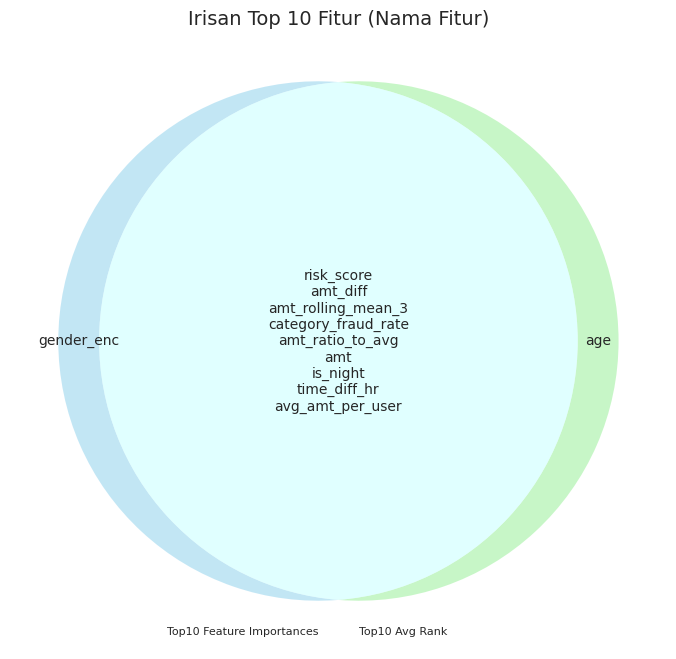

In [ ]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Set fitur
set1 = set(top10_feat['Feature'])  # Top10 feature_importances_
set2 = set(top10['Feature'])       # Top10 Avg_rank

# Buat figure besar
plt.figure(figsize=(10,8))

# Buat Venn diagram 2 set
v = venn2([set1, set2], set_labels=('Top10 Feature Importances', 'Top10 Avg Rank'),
          set_colors=('skyblue','lightgreen'), alpha=0.5)

# Kecilkan font label lingkaran (judul circle)
for label in v.set_labels:
    if label:
        label.set_fontsize(8)

# Masukkan nama fitur di tiap subset
if v.get_label_by_id('10'):  # hanya ada di set1
    v.get_label_by_id('10').set_text("\n".join(set1 - set2))
    v.get_label_by_id('10').set_fontsize(10)
if v.get_label_by_id('01'):  # hanya ada di set2
    v.get_label_by_id('01').set_text("\n".join(set2 - set1))
    v.get_label_by_id('01').set_fontsize(10)
if v.get_label_by_id('11'):  # irisan
    v.get_label_by_id('11').set_text("\n".join(set1 & set2))
    v.get_label_by_id('11').set_fontsize(10)

# Judul
plt.title("Irisan Top 10 Fitur (Nama Fitur)", fontsize=14)

plt.show()

#### Save Model

In [ ]:
# Save model
joblib.dump(best_model, '/content/drive/MyDrive/Proyek/Data/project 2/best_model/best_model_xgb_v3.pkl')

['/content/drive/MyDrive/Proyek/Data/project 2/best_model/best_model_xgb_v3.pkl']

#### Testing Gradio

In [ ]:
# -----------------------------
# Load model
# -----------------------------
model_path = "/content/drive/MyDrive/Proyek/Data/project 2/best_model/best_model_xgb_v3.pkl"
loaded_model = joblib.load(model_path)

In [ ]:
# Threshold optimal dari training (ganti sesuai hasil training)
best_thresh = results_df['Best Threshold'][0]

# -----------------------------
# Fungsi prediksi
# -----------------------------
def predict_fraud_dynamic(input_dict):
    X_input = pd.DataFrame([input_dict])
    # Pastikan urutan kolom sama dengan training
    X_input = X_input[X_train.columns]
    y_proba = loaded_model.predict_proba(X_input)[:,1]
    y_pred = int(y_proba[0] >= best_thresh)
    return {
        "Fraud Probability": float(y_proba[0]),
        "Fraud Prediction": y_pred
    }

# -----------------------------
# Buat input Gradio secara dinamis
# -----------------------------
inputs = []
for col in X_train.columns:
    if X_train[col].dtype in [np.int64, np.float64]:
        inputs.append(gr.Number(label=col))
    elif X_train[col].dtype == "bool":
        inputs.append(gr.Checkbox(label=col))
    else:
        inputs.append(gr.Textbox(label=col))

# Fungsi mapper untuk zip input ke dict
def gradio_input_mapper(*args):
    return dict(zip(X_train.columns, args))

# -----------------------------
# Launch Gradio
# -----------------------------
demo = gr.Interface(
    fn=lambda *args: predict_fraud_dynamic(gradio_input_mapper(*args)),
    inputs=inputs,
    outputs=[
        gr.Number(label="Fraud Probability"),
        gr.Label(label="Fraud Prediction")
    ],
    title="Fraud Detection XGBoost",
    description=f"Testing model XGBoost dengan threshold {best_thresh}"
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9238d4d3ca45da8086.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
